In [1]:
import sys,os
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath('../modules/'))

import healpy as h
import multiprocessing as mp
from modules.settings import global_mmf_settings as gset
from data_preprocess import tiling_the_sphere as tts
from data_preprocess import tile_planck_data as tpd
from filters import modular_multi_matched_filter as mmf
from simulate import cluster_templates as cltemp

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_tiles/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=15.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
datapath=gset.mmfset.paths["result_data"]

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


<IPython.core.display.Javascript object>


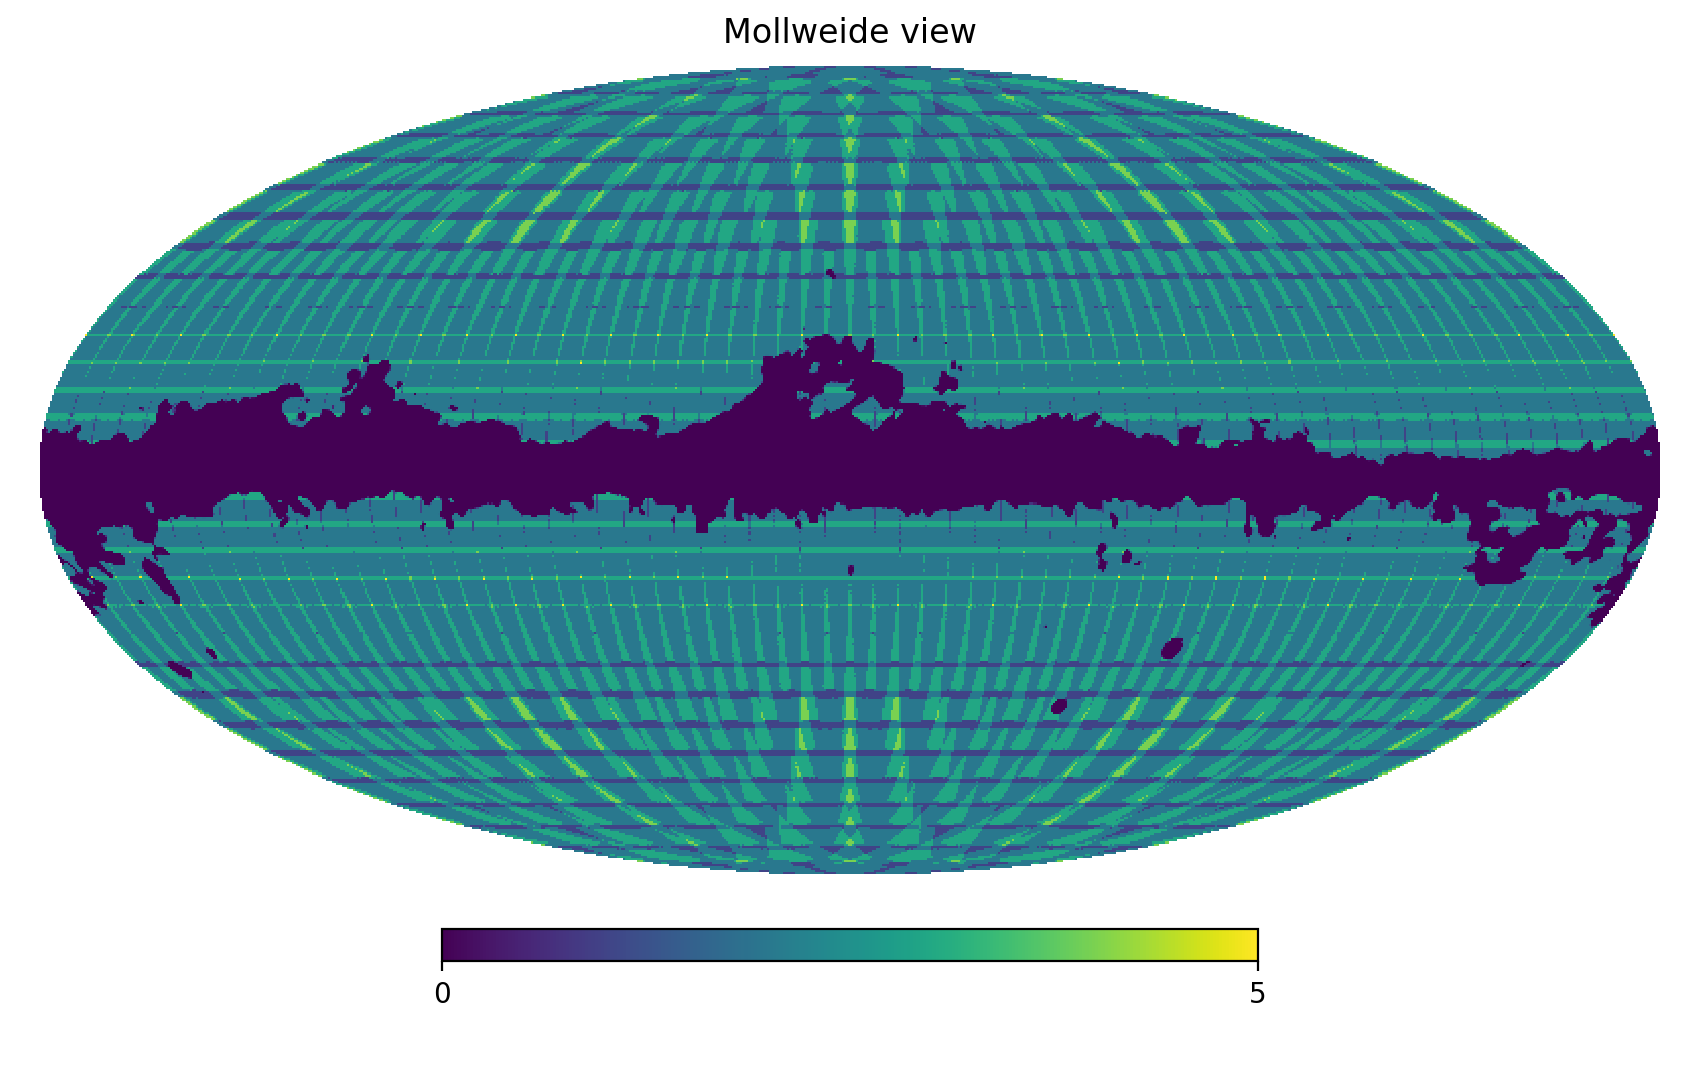

In [3]:
tile_map,fsky_map,apo_mask=tts.return_sky_tile_map()
tiledef=tpd.get_tangent_plane_fnames(fsky_map=fsky_map,fsky_thr=0.3)
h.mollview(tile_map)
filename=figpath + "tile_the_sky.pdf"
plt.savefig(filename,bbox_inches="tight",dpi=200)

In [4]:
# tpd.extract_data_tiles(tiledef)

# def gen_ps_inpainted_data(px):
#     tpd.gen_ps_inpainted_data(px,tiledef)
    
# def parallel_psfill(numprocs):
#     pool=mp.Pool(processes=numprocs)
#     pool.map(gen_ps_inpainted_data,tiledef.keys())
#     pool.close()
#     pool.join()
    
# start=time.time()
# parallel_psfill(4)
# print time.time()-start

In [5]:
from automated_detection import extract_tile_cluster_catalogue_v1 as etcc

In [6]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_step=1.,theta500_min=1.,theta500_max=100.,theta_step=2.)
tmplt.setup_templates()

In [ ]:
def wrap_extract_tile_cluster_catalogue(px):
    x=etcc.extract_tile_cluster_catalogue(px,tiledef,tmplt,genfig=True)

def parallel_etcc(numprocs):
    pool=mp.Pool(processes=numprocs)
#    pool.map(wrap_extract_tile_cluster_catalogue,tiledef.keys())
    pool.map_async(wrap_extract_tile_cluster_catalogue,tiledef.keys())
    pool.close()
    pool.join()

# start=time.time()
# parallel_etcc(32)
# print time.time()-start

In [48]:
start=time.time()
cat,fildata=etcc.extract_tile_cluster_catalogue(4,tiledef,tmplt,genfig=False,remove_sz=True)
print time.time-start

<IPython.core.display.Javascript object>


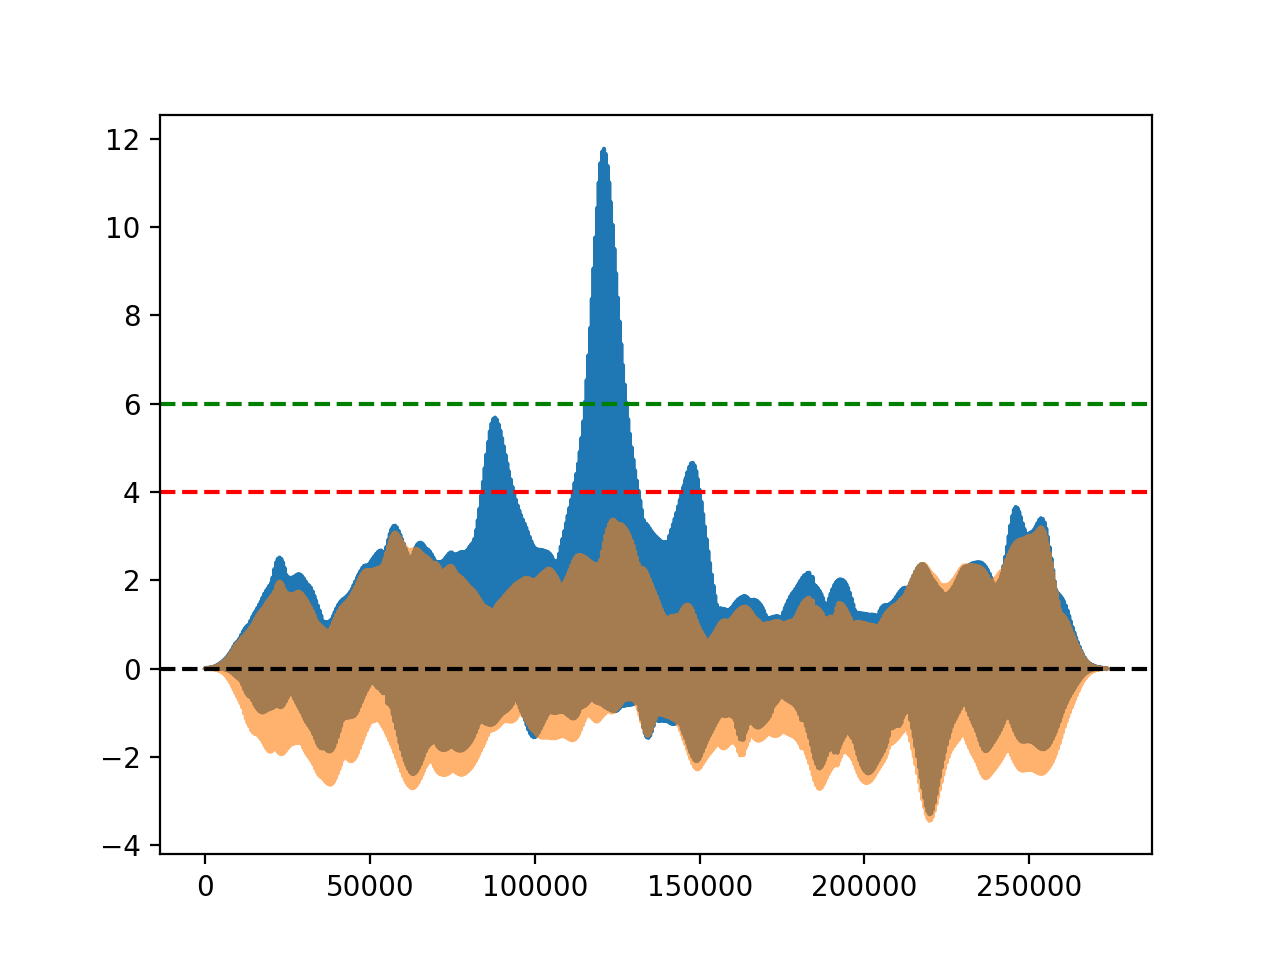

1.2740049124439344e-06
1.0706734956582552e-06


In [52]:
figure()
idx=10
th=cat["theta500"][idx]
err=cat["err_yc"][idx] ; print err
err1=cat["err_yc_rev"][idx] ; print err1
plot(fildata["iter0"][th].ravel()/err)
plot(fildata["iter1"][th].ravel()/err1,alpha=0.6)
axhline(0,linestyle="dashed",color="k")
axhline(4,linestyle="dashed",color="r")
axhline(6,linestyle="dashed",color="g")